In [1]:
import xml.etree.ElementTree as ET
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import pprint
import pickle
import os
import json
import numpy as np
import multiprocessing
import time
from sklearn import metrics
import seaborn as sn
from numpy import asarray
from numpy import savetxt
pp = pprint.PrettyPrinter(indent=4)

In [2]:
import operator

def get_column(list_, n):
    return map(operator.itemgetter(n), list_)

In [3]:
def parse_data(file):
    
    tree = ET.parse(file)
    root = tree.getroot()
    
    data = []
    labels = []
    
    for s_tag in root.iter('s'):
        
        sentence = []
        tags = []
        
        for e_tag in s_tag:
                
            if e_tag.tag == 'w' or e_tag.tag == 'c':
                if e_tag.text is not None:
                    tag = e_tag.attrib['c5']
                    word = e_tag.text.replace(" ", "")
                    
                    sentence.append(word)
                    tags.append(tag)
                    
            elif e_tag.tag == 'mw':
                tag = e_tag.attrib['c5']
                word = ""
                for w_tag in e_tag.iterfind('w'):     
                    word += w_tag.text.replace(" ", "")
                
                sentence.append(word)
                tags.append(tag)
                
            elif e_tag.tag == 'hi' or e_tag.tag == 'corr':
                
                for r_tag in e_tag:
                
                    if r_tag.tag == 'w' or r_tag.tag == 'c':
                        if r_tag.text is not None:
                            tag = r_tag.attrib['c5']
                            word = r_tag.text.replace(" ", "")

                            sentence.append(word)
                            tags.append(tag)

                    elif r_tag.tag == 'mw':
                        tag = r_tag.attrib['c5']
                        word = ""
                        for w_tag in r_tag.iterfind('w'):     
                            word += w_tag.text.replace(" ", "")

                        sentence.append(word)
                        tags.append(tag)
                
        data.append(sentence)
        labels.append(tags)

    return data, labels

In [4]:
def load_dataset(path):

    data = []
    labels = []

    for subdir, dirs, files in os.walk(path):
        for file in files:

            fileName = subdir + '/' + str(file)
            file_data, file_labels = parse_data(fileName)
            data.extend(file_data)
            labels.extend(file_labels)

    return data, labels

In [5]:
# Load Dataset

train_path = 'Train-corpus/'
test_path = 'Test-corpus/'

data, labels = load_dataset(train_path)
test_data, test_labels = load_dataset(test_path)

In [6]:
print(len(data))
print(len(labels))

print(data[0])
print(labels[0])

print(len(test_data))
print(len(test_labels))

print(test_data[11])
print(test_labels[11])

483629
483629
['Wonder', 'boy', "'s", 'eyes', 'on', 'Wembley', '.']
['VVB-NN1', 'NN1', 'POS', 'NN2', 'PRP', 'NP0', 'PUN']
200468
200468
['These', '‘', 'communities', '’', 'are', 'of', 'two', 'kinds', '.']
['DT0', 'PUQ', 'NN2', 'PUQ', 'VBB', 'PRF', 'CRD', 'NN2', 'PUN']


In [7]:
# Load JSON Files

with open('words.json') as f:
    word_dict = json.load(f)
with open('tags.json') as f:
    tag_dict = json.load(f)
with open('word_tags.json') as f:
    word_tags_dict = json.load(f)

In [8]:
print(len(tag_dict))
print(len(word_dict))
print(len(word_tags_dict))

61
193511
253488


In [9]:
def compute_word_tag_freq_matrix():
    
    rows = len(word_dict.keys())
    cols = len(tag_dict.keys())
    
    mat = [[0 for i in range(cols)] for j in range(rows)] 
    
    i=0
    for word in word_dict.keys():
        j=0
        for tag in tag_dict.keys():
            case = word + "_" + tag
            if case in word_tags_dict.keys():
                mat[i][j] = word_tags_dict[case]
            j = j + 1
        i = i + 1
        
    return mat

In [10]:
freq_matrix = compute_word_tag_freq_matrix()
savetxt('freq_matrix.csv', freq_matrix, delimiter=',')

In [11]:
def compute_emission_prob_matrix(freq):
    rows = len(freq_matrix)
    cols = len(freq_matrix[0])
    mat = freq
    
    for j in range(0, cols):
        col_slice = list(get_column(mat, j))
        total = sum(col_slice)
        for i in range(rows):
            mat[i][j] = mat[i][j]/total
    
    return mat

In [12]:
emission_mat = compute_emission_prob_matrix(freq_matrix)
savetxt('emission_mat.csv', emission_mat, delimiter=',')

In [13]:
tags_index_dict = dict(zip(list(tag_dict.keys()),range(0, len(tag_dict.keys()))))
word_index_dict = dict(zip(list(word_dict.keys()),range(0, len(word_dict.keys()))))
tags_inv_dict = {v: k for k, v in tags_index_dict.items()}
word_inv_dict = {v: k for k, v in word_index_dict.items()}
print(tags_index_dict)

{'VVB': 0, 'NN1': 1, 'POS': 2, 'NN2': 3, 'PRP': 4, 'NP0': 5, 'VVZ': 6, 'AT0': 7, 'PRF': 8, 'AJ0': 9, 'ORD': 10, 'DT0': 11, 'VM0': 12, 'VVI': 13, 'TO0': 14, 'VHI': 15, 'PNI': 16, 'VBZ': 17, 'XX0': 18, 'AV0': 19, 'CJC': 20, 'PNP': 21, 'PNQ': 22, 'DPS': 23, 'VHZ': 24, 'VVN': 25, 'NN0': 26, 'CJT': 27, 'CJS': 28, 'AVQ': 29, 'AVP': 30, 'DTQ': 31, 'AJS': 32, 'VHD': 33, 'CRD': 34, 'VVG': 35, 'VVD': 36, 'VBD': 37, 'VBG': 38, 'VBI': 39, 'AJC': 40, 'UNC': 41, 'VHB': 42, 'VBN': 43, 'PNX': 44, 'VHG': 45, 'EX0': 46, 'VBB': 47, 'VDN': 48, 'VDD': 49, 'ITJ': 50, 'ZZ0': 51, 'VHN': 52, 'VDB': 53, 'VDZ': 54, 'VDI': 55, 'VDG': 56, 'PUN': 57, 'PUQ': 58, 'PUL': 59, 'PUR': 60}


In [14]:
def get_index(tag, isPrev=True):
    if tag == "start":
        return [0]
    if tag == "end":
        return [len(tags_index_dict.keys())]
    if "-" in tag:
        a1 = tags_index_dict[tag[:3]]
        a2 = tags_index_dict[tag[4:]]
        return [a1, a2]
    else:
        a = tags_index_dict[tag]
        return [a]

In [15]:
def compute_tag_tag_frequency_matrix(data, labels):
    
    rows = len(tag_dict.keys()) + 1
    cols = len(tag_dict.keys()) + 1
    
    mat = [[0 for i in range(cols)] for j in range(rows)] 
    
    i=0
    for sentence in data:
        prev_tag = "start"
        curr_tag = "start"
        
        j=0
        for word in sentence:
            prev_tag = curr_tag
            curr_tag = labels[i][j]
            
            prev_index = get_index(prev_tag)
            curr_index = get_index(curr_tag)
            
            a1=0
            a2=0
            b1=0
            b2=0
            
            if len(prev_index) == 1:
                a = prev_index[0]
                if prev_tag != "start":
                    a = a + 1
                if len(curr_index) == 1:
                    b = curr_index[0]
                    mat[a][b] = mat[a][b] + 1
                else:
                    b1 = curr_index[0]
                    b2 = curr_index[1]
                    mat[a][b1] = mat[a][b1] + 1
                    mat[a][b2] = mat[a][b2] + 1
                    
            else:
                a1 = prev_index[0] + 1
                a2 = prev_index[1] + 1
                if len(curr_index) == 1:
                    b = curr_index[0]
                    mat[a1][b] = mat[a1][b] + 1
                    mat[a2][b] = mat[a2][b] + 1
                    
                else:
                    b1 = curr_index[0]
                    b2 = curr_index[1]
                    mat[a1][b1] = mat[a1][b1] + 1
                    mat[a1][b2] = mat[a1][b2] + 1
                    mat[a2][b1] = mat[a2][b1] + 1
                    mat[a2][b2] = mat[a2][b2] + 1
            
            j=j+1
            
        curr_index = get_index(curr_tag)
        
        if len(curr_index) == 1:
            b = curr_index[0] + 1
            mat[b][61] = mat[b][61] + 1
        else:
            b1 = curr_index[0] + 1
            b2 = curr_index[1] + 1
            mat[b1][61] = mat[b1][61] + 1
            mat[b2][61] = mat[b2][61] + 1
            
        i=i+1
        
    return mat

In [16]:
tag_tag_freq_matrix = compute_tag_tag_frequency_matrix(data, labels)
savetxt('tag_tag_matrix.csv',tag_tag_freq_matrix, delimiter=',')

In [17]:
def compute_transition_prob_matrix(freq):
    rows = len(freq)
    cols = len(freq[0])
    
    mat = np.array(freq, dtype=float)
    
    for i in range(0, rows):
        
        total = float(sum(mat[i]))
        if total == 0:
            total = 1
            
        mat[i] = [x/total for x in mat[i]]
            
    return mat

In [18]:
transition_mat = compute_transition_prob_matrix(tag_tag_freq_matrix)
savetxt('transition_matrix.csv', transition_mat, delimiter=',')

In [19]:
possible_tags = {}
count = 0

def compute_possible_combinations(data, labels):
    
    for i, sentence in enumerate(data):
        for j, word in enumerate(sentence):
            label = labels[i][j]
            
            if "-" in label:
                l1 = label[:3]
                l2 = label[4:]
                try:
                    if l1 not in possible_tags[word]:
                        possible_tags[word].append(l1)
                    if l2 not in possible_tags[word]:
                        possible_tags[word].append(l2)
                except:
                    init = []
                    init.append(l1)
                    init.append(l2)
                    possible_tags[word] = init
            else:
                try:
                    if label not in possible_tags[word]:
                        possible_tags[word].append(label)
                except:
                    init = []
                    init.append(label)
                    possible_tags[word] = init
            
compute_possible_combinations(data, labels)
compute_possible_combinations(test_data, test_labels)

In [20]:
# Use Laplace Smoothing
def probability_word_given_tag(word, tag):
    
    count_tag = tag_dict[tag]
    
    if word+'_'+tag in word_tags_dict.keys():
        count_word_tag = word_tags_dict[word+'_'+tag]

        return (count_word_tag)/(count_tag)
    
    else:
        return 1/(count_tag + 1)

In [21]:
def Viterbi(sentence):
    predicted = []
    cache = {}
    for index, word in enumerate(sentence):
        if index == 0:
            cache[index] = {}
            tags = possible_tags[word]
            for tag in tags:

                if word in word_dict.keys():
                    word_index = word_index_dict[word]
                    tag_index = tags_index_dict[tag]

                    cache[index][tag] = ['##', transition_mat[0][tag_index] * emission_mat[word_index][tag_index]]

                else:
                    tag_index = tags_index_dict[tag]
                    cache[index][tag] = ['##', transition_mat[0][tag_index] * probability_word_given_tag(word, tag)]

        else:
            cache[index] = {}
            prev_states = list(cache[index-1].keys())
            
            tags = possible_tags[word]
            for tag in tags:
                temp = []
                for prev_state in prev_states:
                    case = word + "_" + tag
                            
                    if word in word_dict.keys():
                        word_index = word_index_dict[word]
                        curr_index = tags_index_dict[tag]
                        prev_index = tags_index_dict[prev_state]+1

                        temp.append(cache[index-1][prev_state][1] * transition_mat[prev_index][curr_index] * emission_mat[word_index][curr_index])
                    else:
                        curr_index = tags_index_dict[tag]
                        prev_index = tags_index_dict[prev_state]+1
                        temp.append(cache[index-1][prev_state][1] * transition_mat[prev_index][curr_index] * probability_word_given_tag(word, tag))
                        
                max_temp_index = temp.index(max(temp))
                best_prev_tag = prev_states[max_temp_index]
                cache[index][tag] = [best_prev_tag, max(temp)]
    
    index = len(sentence)
    cache[index] = {}
    prev_states = list(cache[index-1].keys())
    
    temp = []
    for prev_state in prev_states:

        curr_index = 61
        prev_index = tags_index_dict[prev_state] + 1

        temp.append(cache[index-1][prev_state][1] * transition_mat[prev_index][curr_index])   

    max_temp_index = temp.index(max(temp))
    best_prev_tag = prev_states[max_temp_index]
    cache[index]['&&'] = [best_prev_tag, max(temp)]

    # Backtracing to extract the best possible tags for the 
    pred_tags = []
    all_word_index = cache.keys()
    last_word_index = max(all_word_index)
    
    for index in range(len(all_word_index)):
        
        word_index = last_word_index - index
        
        if word_index == last_word_index:
            pred_tags.append(cache[word_index]['&&'][0])
            
        if word_index < last_word_index and word_index > 0:
            pred_tags.append(cache[word_index][pred_tags[len(pred_tags)-1]][0])
            
    predicted.append(list(reversed(pred_tags)))

    return predicted[0]

In [22]:
print(Viterbi(['These', '‘', 'communities', '’', 'are', 'of', 'two', 'kinds', '.']))
print(Viterbi(['Average', 'foot', 'position', 'for', '11', 'stone', '(', '70kg', ')', 'sailors', '.']))

# ['DT0', 'PUQ', 'NN2', 'PUQ', 'VBB', 'PRF', 'CRD', 'NN2', 'PUN']
# ['AJ0', 'NN1', 'NN1', 'PRP', 'CRD', 'NN1', 'PUL', 'NN0', 'PUR', 'NN2', 'PUN']

['DT0', 'PUQ', 'NN2', 'PUQ', 'VBB', 'PRF', 'CRD', 'NN2', 'PUN']
['AJ0', 'NN1', 'NN1', 'PRP', 'CRD', 'NN1', 'PUL', 'NN0', 'PUR', 'NN2', 'PUN']


In [23]:
def get_predictions(data):
    pred = []
    for index, sentence in enumerate(data):
        if len(sentence) != 0:
            pred.append(Viterbi(sentence))
        else:
            pred.append([])
        if ((index+1) % 10000==0):
            print("Predicted: %d " % (index+1))  
    return pred

In [24]:
preds = get_predictions(test_data)

Predicted: 10000 
Predicted: 20000 
Predicted: 30000 
Predicted: 40000 
Predicted: 50000 
Predicted: 60000 
Predicted: 70000 
Predicted: 80000 
Predicted: 90000 
Predicted: 100000 
Predicted: 110000 
Predicted: 120000 
Predicted: 130000 
Predicted: 140000 
Predicted: 150000 
Predicted: 160000 
Predicted: 170000 
Predicted: 180000 
Predicted: 190000 
Predicted: 200000 


In [25]:
def get_accuracy(test_data, test_labels, preds):
    
    correct = 0
    incorrect = 0
    
    print("Total: %d" % len(test_data))
    
    t0 = time.process_time()
    
    for index, pred_labels in enumerate(preds):
        true_labels = test_labels[index]
        
        for i, pred_label in enumerate(pred_labels):
            if pred_label in true_labels[i]:
                correct = correct + 1
            else:
                incorrect = incorrect + 1
                
    print("Evaluated Words: %d " % (incorrect + correct))   
    print("Correct: %d " % (correct))   
    print("Incorrect: %d " % (incorrect))   
    print("Time Taken: %.2f \n " % (time.process_time()-t0))
    
    print("Final Accuracy = %.06f"  % (correct/(correct+incorrect)))

In [26]:
get_accuracy(test_data, test_labels, preds)

Total: 200468
Evaluated Words: 4094999 
Correct: 4016270 
Incorrect: 78729 
Time Taken: 0.63 
 
Final Accuracy = 0.980774


In [27]:
tags = list(tag_dict.keys())
def get_confusion_matrix(preds, test_labels):
    y_true = []
    y_pred = []
    for i in preds:
        for j in i:
            y_pred.append(j)
    for i in test_labels:
        for j in i:
            y_true.append(j)
    plt.figure(figsize=(25, 22), dpi=10)
    df_cm = pd.DataFrame(metrics.confusion_matrix(y_true, y_pred, tags), tag_dict.keys(), tag_dict.keys())
    sn.set(font_scale=1.0)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 5}) # font size
    # plt.show()
    # plt.savefig('confusion_matrix.png')
    plt.savefig('cm_hmm.png', format='png', dpi=200)
    # print(metrics.confusion_matrix(y_true, y_pred))


/home/aseem/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass labels=['VVB', 'NN1', 'POS', 'NN2', 'PRP', 'NP0', 'VVZ', 'AT0', 'PRF', 'AJ0', 'ORD', 'DT0', 'VM0', 'VVI', 'TO0', 'VHI', 'PNI', 'VBZ', 'XX0', 'AV0', 'CJC', 'PNP', 'PNQ', 'DPS', 'VHZ', 'VVN', 'NN0', 'CJT', 'CJS', 'AVQ', 'AVP', 'DTQ', 'AJS', 'VHD', 'CRD', 'VVG', 'VVD', 'VBD', 'VBG', 'VBI', 'AJC', 'UNC', 'VHB', 'VBN', 'PNX', 'VHG', 'EX0', 'VBB', 'VDN', 'VDD', 'ITJ', 'ZZ0', 'VHN', 'VDB', 'VDZ', 'VDI', 'VDG', 'PUN', 'PUQ', 'PUL', 'PUR'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


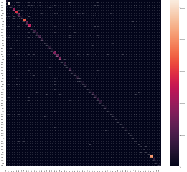

In [28]:
get_confusion_matrix(preds, test_labels)